In [45]:
import sys
sys.path.insert(0, '../')

import numpy as np
import torch
from torch.autograd import Variable
from FuseNet import FuseNet, CrossEntropy2d
from Solver_FuseNet import Solver_SS
import torch.nn.functional as F
from utils.data_utils_class import get_data

from dataloaders.NYUDv2Loader import *
from dataloaders.SUNRGBDLoader import *

%matplotlib inline
from utils.visual_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
gpu_device = 0
torch.cuda.set_device(gpu_device)

In [3]:
resume = False
dset_type = 'NYU'
train_data, test_data = get_data(dset_type=dset_type)
print ("[PROGRESS] %s dataset retrieved"  %(dset_type))

train_loader    = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=1)
test_loader     = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=1)

[PROGRESS] NYU dataset retrieved


In [4]:
# it should be 40!
best_model = FuseNet(40).cuda() 
checkpoint = torch.load('../models/nyu/checkpoint25.pth.tar')
best_model.load_state_dict(checkpoint['state_dict']) 

In [41]:
def evaluate(model, num_classes, val_loader):
    # Calculate IoU and Mean accuracies
    print num_classes
    val_confusion = np.zeros((num_classes,3))
    IoU = 0
    mean_acc = 0

    for batch in val_loader:
        val_rgb_inputs  = Variable(batch[0].cuda(gpu_device))
        val_d_inputs    = Variable(batch[1].cuda(gpu_device))
        val_labels      = Variable(batch[2].cuda(gpu_device))
        val_outputs     = model(val_rgb_inputs, val_d_inputs)
        _, val_preds    = torch.max	(val_outputs, 1)

        val_labels = val_labels - 1

        for i in range(num_classes):
            val_labels_mask = val_labels == i
            val_preds_mask = val_preds == i
            TP = np.sum((val_preds == val_labels)[val_labels_mask].data.cpu().numpy())
            #print TP
            val_confusion[i,0] += TP 
            val_confusion[i,1] += np.sum((val_labels==val_labels)[val_labels_mask].data.cpu().numpy()) - TP 
            val_confusion[i,2] += np.sum((val_preds==val_preds)[val_preds_mask].data.cpu().numpy()) - TP 

    for i in range(num_classes):
        TP, FP, FN = val_confusion[i]
        print(TP+FP,FN)
        IoU += TP / (TP + FP + FN)
        mean_acc += TP / (TP + FP)
    IoU /= num_classes
    mean_acc /= num_classes

    print("        Best VALIDATION IoU: %.3f Mean Accuracy: %.3f" % (IoU, mean_acc))

In [37]:
evaluate(best_model)

40
(10640273.0, 4990416.0)
(4489928.0, 1784352.0)
(2899325.0, 1517659.0)
(2049166.0, 732790.0)
(1640753.0, 1379005.0)
(1543978.0, 828497.0)
(1148042.0, 659767.0)
(1184338.0, 756398.0)
(1014467.0, 1086624.0)
(980712.0, 483353.0)
(1102822.0, 677813.0)
(714923.0, 396427.0)
(905990.0, 392670.0)
(629990.0, 369648.0)
(378267.0, 545093.0)
(623564.0, 311136.0)
(464011.0, 186379.0)
(434724.0, 243267.0)
(459332.0, 269531.0)
(428154.0, 154355.0)
(268435.0, 397400.0)
(577772.0, 479685.0)
(330452.0, 207616.0)
(212865.0, 139682.0)
(212514.0, 115513.0)
(113853.0, 76570.0)
(204112.0, 139416.0)
(172709.0, 67085.0)
(220076.0, 165973.0)
(193267.0, 49949.0)
(143474.0, 71348.0)
(155367.0, 64261.0)
(122432.0, 39008.0)
(264716.0, 90311.0)
(143724.0, 85557.0)
(150539.0, 33883.0)
(128519.0, 95620.0)
(805459.0, 1109842.0)
(1042056.0, 1007868.0)
(2437369.0, 2710625.0)
        Best VALIDATION IoU: 0.233 Mean Accuracy: 0.363
        Orgnal. FuseNet Accuracy: 0.66  IoU: 0.327 Mean Accuracy: 0.434


In [10]:
checkpoint['best_val_acc']

0.657392311098506

# NYUDv2

In [4]:
data_visualizer = DataVisualizer()

v_loader = NYUDv2Loader('/home/dongwonshin/Desktop/Datasets/NYUDv2/', split='val', is_transform=True, img_norm=True, img_size=(240,320))
val_loader = data.DataLoader(v_loader, batch_size=4, num_workers=16)

In [16]:
model = FuseNet(14).cuda()
checkpoint = torch.load('../models/by my dataloader/nyu/checkpoint25.pth.tar')
model.load_state_dict(checkpoint['state_dict']) 

In [27]:
for data in val_loader:

    rgb_inputs  = Variable(data[0].cuda(gpu_device))
    d_inputs    = Variable(data[1].cuda(gpu_device))
    labels      = Variable(data[2].cuda(gpu_device))
    val_outputs     = model(rgb_inputs, d_inputs)
    _, val_preds    = torch.max	(val_outputs, 1)
    
    val_preds = val_preds + 1
    
    print(np.unique(labels))
    break;

[ 0  3  4  5  6  7  8  9 10 12 13]


In [28]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

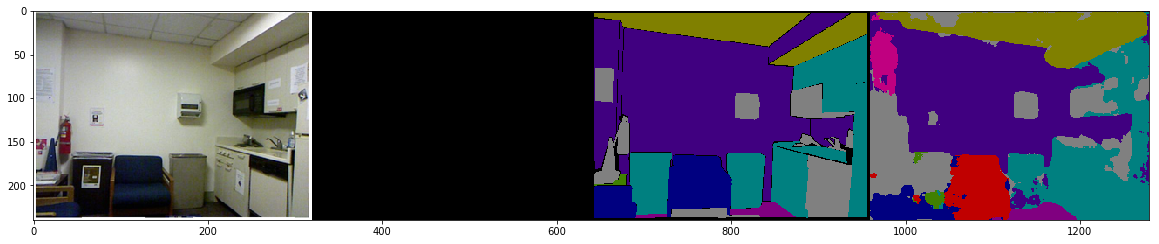

In [31]:
idx = 0
data_visualizer.visualize_all(rgb_inputs[idx], d_inputs[idx], labels[idx], val_preds[idx], unnormalized_color=True, unnormalized_depth=True)

In [42]:
evaluate(model, 13, val_loader)

13
(2048477.0, 485432.0)
(330180.0, 182545.0)
(645770.0, 339420.0)
(1640338.0, 1316742.0)
(4915685.0, 1384770.0)
(6972920.0, 3703186.0)
(6070799.0, 4824643.0)
(1104096.0, 567384.0)
(1542769.0, 649335.0)
(1778309.0, 1106227.0)
(212285.0, 84942.0)
(11829309.0, 4627682.0)
(2546211.0, 1163271.0)
        Best VALIDATION IoU: 0.416 Mean Accuracy: 0.611


# SUNRGBD

In [51]:
gpu_device = 3
num_classes = 40

In [48]:
data_visualizer = DataVisualizer()

v_loader = SUNRGBDLoader(gpu_device, '/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD/', split='val', is_transform=True, img_norm=True, img_size=(240,320))
val_loader = data.DataLoader(v_loader, batch_size=4, num_workers=16)

In [53]:
model = FuseNet(gpu_device, num_classes).cuda(gpu_device)
checkpoint = torch.load('../models/sun/checkpoint25.pth.tar')
model.load_state_dict(checkpoint['state_dict']) 

In [54]:
for data in val_loader:

    rgb_inputs  = Variable(data[0].cuda(gpu_device))
    d_inputs    = Variable(data[1].cuda(gpu_device))
    labels      = Variable(data[2].cuda(gpu_device))
    val_outputs     = model(rgb_inputs, d_inputs)
    _, val_preds    = torch.max	(val_outputs, 1)
    
    val_preds = val_preds + 1
    
    print(np.unique(labels))
    break;

/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD/test/label/label-000023.png
[ 0  1  2  4  6  7  9 11 14 17 18 19 22 32 35 37]


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fd7b6b42650>> ignored


In [56]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

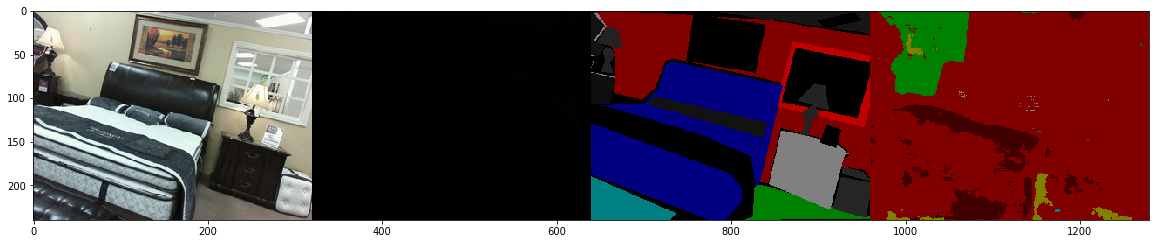

In [58]:
idx = 1
data_visualizer.visualize_all(rgb_inputs[idx], d_inputs[idx], labels[idx], val_preds[idx], unnormalized_color=True, unnormalized_depth=True)

In [59]:
evaluate(model, 40, val_loader)

40
/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD/test/label/label-000023.png


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fd7b3df8f50>> ignored


RuntimeError: cuda runtime error (2) : out of memory at /pytorch/aten/src/THC/generic/THCStorage.cu:58